## In this notebook, we assign frame properties to candidates detected in the previous step.

**Necessary files:**
 - event_df (event specific dataframe with cleaned text)
 - frame_properties (dictionary with frames and their related keywords)
 - event_tagged_tweets (annotated tweets using stanza library)
 - model (word2vec model trained on event specific data (or the entire set))
 - cands (dataframe with tagged candidates, their heads, sets of phrases heads and cand_types) 
 - merged_dict (dictionary with merged candidates)
 

In [1]:
from nltk.corpus import stopwords
from collections import defaultdict
import nltk
import os
import pickle
import stanza
import pandas as pd
from  tqdm.notebook import tqdm

nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

tigray_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_tigray_clean.csv" # location of Tigray dataset
greece_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_greece_clean.csv" # location of Greece dataset
rohingya_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_rohingya_clean.csv" # location of Rohingya dataset
channel_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_channel_clean.csv" # location of Channel dataset

def pickle_file(file_name, file_to_dump):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path +  fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, 'wb') as fp:
        pickle.dump(file_to_dump, fp)

def load_pickle(file_name):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path + fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)
    
def read_event_df(event_name):
    data_url = fr"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_{event_name}_clean.csv"
    directory_path = os.getcwd() + "/../../../../" + data_url 
    event_df = pd.read_csv(directory_path, index_col=0)
    event_df.reset_index(drop=True, inplace=True)
    print(f'loaded {event_df.shape[0]} tweets!')
    return event_df




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikodemicek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Creating word frame properties dictionary

In [2]:
def get_bag_of_words(df_col):
    
    df_col = df_col[~df_col.isnull()] 
    df_col = df_col.apply(lambda x: x.split(' '))     
    bag_of_words = set([word for tweet_words in df_col for word in tweet_words if len(word)>1])

    return list(bag_of_words)


def embed_words(bag_of_words):
    from time import time
    from sentence_transformers import SentenceTransformer
    #sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

    print(f'there are {len(bag_of_words)} entities to be encoded')
    t0 = time()
    word_embeddings = sbert_model.encode(bag_of_words)
    print(f'Training embeddings took {time()-t0} seconds')
    return word_embeddings

In [39]:
event_df = read_event_df('greece')
bow = get_bag_of_words(event_df["text_stm"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('greece_word_embeddings',model)

loaded 137462 tweets!
there are 50060 entities to be encoded
Training embeddings took 819.3549072742462 seconds


In [40]:
event_df = read_event_df('channel')
bow = get_bag_of_words(event_df["text_stm"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('channel_word_embeddings',model)

loaded 173758 tweets!
there are 49807 entities to be encoded
Training embeddings took 686.8561251163483 seconds


In [41]:
event_df = read_event_df('tigray')
bow = get_bag_of_words(event_df["text_stm"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('tigray_word_embeddings',model)

loaded 42853 tweets!
there are 25973 entities to be encoded
Training embeddings took 368.55032300949097 seconds


In [42]:
event_df = read_event_df('rohingya')
bow = get_bag_of_words(event_df["text_stm"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('rohingya_word_embeddings',model)

loaded 29432 tweets!
there are 19460 entities to be encoded
Training embeddings took 271.6321425437927 seconds


## Define frames

In [33]:
#it is called greece just to go straight into the folder, but frames are valid for all events
frame_properties = load_pickle('channel_frame_devices')
print(frame_properties)

In [35]:
# the frames are named here based on the words in the dictionary values
frame_properties['political'] = frame_properties.pop(0)
frame_properties['settlement'] = frame_properties.pop(1)
frame_properties['economic'] = frame_properties.pop(2)
frame_properties['criminal'] = frame_properties.pop(3)
frame_properties['relief'] = frame_properties.pop(4)
frame_properties['migration'] = frame_properties.pop(5)
frame_properties['integration'] = frame_properties.pop(6)


In [ ]:
print(frame_properties)

In [37]:
pickle_file('channel_final_frames',frame_properties)


## Assign frame properties to words in corpus

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# run this if  [event]_word_properties does not exist yet
def assign_word_frame_properties(tweet_words,model,frame_properties):
    #print('assigning frame properties to words from tweets...')
    word_properties = defaultdict(dict)
    #for i in tqdm(tweets_corpus):
     #   tweet_words = [word.lower() for word in i.split() if word not in stop_words and len(word)>1]
    for word in tqdm(tweet_words):
        #print(word)
        word = lemma.lemmatize(word)
        property_list = []
        for prop in list(frame_properties.keys()):
            try:
                weights = [cosine_similarity(model[word].reshape(1,-1), model[seed].reshape(1,-1)) for seed in frame_properties[prop]]
                #print(weights)
                if max(weights)>0.7:
                    word_properties[word][prop] = max(weights)
                    #print(word,prop)
            except KeyError:
                pass
    return  word_properties   

def get_word_properties(event_name):
    event_df = read_event_df(event_name)
    model = load_pickle(f'{event_name}_word_embeddings')
    frame_properties = load_pickle('greece_final_frames')
    tqdm.pandas()
    word_properties = assign_word_frame_properties(get_bag_of_words(event_df['text_stm']),model,frame_properties)
    pickle_file(f'{event_name}_word_properties', word_properties)
    return word_properties


In [44]:
word_properties = get_word_properties('greece')

loaded 137462 tweets!


  0%|          | 0/50060 [00:00<?, ?it/s]

In [ ]:
word_properties = get_word_properties('channel')

loaded 173758 tweets!


  0%|          | 0/49807 [00:00<?, ?it/s]

In [17]:
word_properties = get_word_properties('tigray')

loaded 42853 tweets!


  0%|          | 0/25973 [00:00<?, ?it/s]

In [11]:
word_properties = get_word_properties('rohingya')

loaded 29432 tweets!


  0%|          | 0/19460 [00:00<?, ?it/s]

In [75]:
word_properties

defaultdict(dict,
            {'movementeu': {'migration': array([[0.82470715]], dtype=float32)},
             'humanity': {'integration': array([[1.0000002]], dtype=float32)},
             'votefor': {'political': array([[0.83867294]], dtype=float32)},
             'teenaged': {'integration': array([[0.7122773]], dtype=float32)},
             'broke': {'vulnerability': array([[0.99999994]], dtype=float32)},
             'soldiera': {'criminal': array([[0.8141879]], dtype=float32)},
             'penniless': {'vulnerability': array([[0.70448124]], dtype=float32)},
             'solves': {'humanitarian': array([[0.70915544]], dtype=float32)},
             'illegalimmigrant': {'criminal': array([[0.7532855]], dtype=float32)},
             'hurt': {'vulnerability': array([[0.741308]], dtype=float32)},
             'forbade': {'security': array([[0.712633]], dtype=float32)},
             'desperate': {'vulnerability': array([[0.99999994]], dtype=float32)},
             'firends': {'violenc

In [14]:
len(word_properties)

764

## Assign frame properties 

In [4]:
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
def get_ent_head(entity):
    if len(word_tokenize(entity))>1:
        entity_doc = en_nlp(entity)
        #the root of NP has value 0. Since head is only one and stored in a list, we pick item [0]
        return [word.text for tweet_ent in entity_doc.sentences for word in tweet_ent.words if word.head == 0][0]
    else:
        return entity


en_nlp = stanza.Pipeline("en",  
                          tokenize_pretokenized=False,
                          processors = "tokenize,pos,lemma,depparse",
                          verbose=False)

In [ ]:
def assign_frame_properties(event_df, tagged_tweets,event_ents,frame_properties,word_properties):
    # import these modules 
    from collections import defaultdict
    from nltk.stem import WordNetLemmatizer 
    import numpy as np
    
    def find_framed_words(ent_to_add, ent_to_compare,frame_properties,word_properties):
        #add frame by word choice 
        rep_head = get_ent_head(ent_to_compare)
        add_dataframe_entry(ent_to_add,rep_head,frame_properties,word_properties)

        #find all dependencies of the entity head
        for related in range(len(ent_words)):
            ent_word = ent_words[related][1].lower()
            if rep_head == ent_word:
                related_word = lemma.lemmatize(ent_words[related][2].lower())
                #add frame by labeling
                add_dataframe_entry(ent_to_add,related_word,frame_properties,word_properties) 
            elif rep_head == ent_words[related][2].lower() and ent_words[related][2].lower() in stop_words:
                add_dataframe_entry(ent_to_add,ent_word,frame_properties,word_properties) 
                
                
    
    def add_dataframe_entry(ent,framing_word,frame_properties,word_properties):
        #append a dataframe row with the entity and its assignment to a frame
        ent_frames['entity'].append(ent)
        ent_frames['framing_word'].append(framing_word)
        ent_frames['date'].append(event_df['date'][tweet_id])
        ent_frames['tweet_id'].append(event_df['id'][tweet_id])
        
        for frame_property in list(frame_properties.keys()):
            
            #append the weight towards a frame to the entity row
            try:
                frame_weight = word_properties[framing_word][frame_property][0][0]
                ent_frames[frame_property].append(frame_weight)
                
            except KeyError:
                ent_frames[frame_property].append(np.NaN)
 
                        
    lemma = WordNetLemmatizer() 
    ent_frames = defaultdict(list)
    entities = list(event_ents.keys())[:10] + ['refugees','migrants']

    framed_words = pd.DataFrame(columns=['word','date','framing_word','tweet_id',list(frame_properties.keys())])
    event_df[['date','time']] = event_df['created_at'].str.split(' ',expand=True)
    
    for tweet_id in tqdm(event_df.index):
        clean_tweet = event_df['text_alphanum'][tweet_id]
        ent_words = [[word.id, word.text,sent.words[word.head-1].text] for sent in tagged_tweets[tweet_id].sentences for word in sent.words]
        #print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in tagged_tweets[tweet_id].sentences for word in sent.words], sep='\n')
        #print(len(cand_df['candidates']))
        #print(ent_words)
        for ent in entities:
            #check if the entity is in the tweet
            if f' {ent} ' in f' {clean_tweet} ':
                loop_switch = False
                #if the entity is in the tweet, check if there is a merged entity that contains entity text
                for merged_ent in event_ents[ent]:
                    if f' {ent} ' in f' {merged_ent} ' and f' {merged_ent} ' in f' {clean_tweet} ':
                        # if trie, use merged_ent to find framed words. Since the list is sorted, loop is escaped once true
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        loop_switch=True
                        break
                    #elif f' {ent} ' in f' {clean_tweet} and f' {merged_ent} ' in f' {clean_tweet} ':
                # if there isn't a merged entity that contains entity text, use the main entity to find framed words    
                if loop_switch==False:
                    find_framed_words(ent,ent,frame_properties,word_properties)
            else:
                #if the main entity isn't in the tweet, look over its merged entities and add frames if it is contained
                for merged_ent in event_ents[ent]:
                    if f' {merged_ent} ' in f' {clean_tweet} ':
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        break
    
    return ent_frames
                
        

In [50]:
def get_framed_entities(event_name):
    event_df = read_event_df(event_name)
    tagged_tweets = load_pickle(f'{event_name}_tagged_tweets')
    event_ents = load_pickle(f'{event_name}_what_merged')
    frame_properties = load_pickle(f'{event_name}_final_frames')
    word_properties = load_pickle(f'{event_name}_word_properties')

    #sort the values in merged entities dictionary so the longest are first
    for key,value in event_ents.items():
        event_ents[key] = sorted(value,key=len, reverse=True)

    ent_frames = assign_frame_properties(event_df,tagged_tweets,event_ents)

    framed_entities = pd.DataFrame.from_dict(ent_frames)

    pickle_file(f'{event_name}_framed_entities',framed_entities)
    return framed_entities

In [52]:
#event_name = 'greece'
#event_df = read_event_df(event_name)
#tagged_tweets = load_pickle(f'{event_name}_tagged_tweets')
#event_ents = load_pickle(f'{event_name}_what_merged')
frame_properties = load_pickle('greece_final_frames')
word_properties = load_pickle('greece_word_properties')

#sort the values in merged entities dictionary so the longest are first
for key,value in event_ents.items():
    event_ents[key] = sorted(value,key=len, reverse=True)

ent_frames = assign_frame_properties(event_df,tagged_tweets,event_ents)

framed_entities = pd.DataFrame.from_dict(ent_frames)
pickle_file(f'{event_name}_framed_entities',framed_entities)

  0%|          | 0/137462 [00:00<?, ?it/s]

In [ ]:
event_name = 'channel'
event_df = read_event_df(event_name)
tagged_tweets = load_pickle(f'{event_name}_tagged_tweets')
event_ents = load_pickle(f'{event_name}_what_merged')
frame_properties = load_pickle(f'{event_name}_final_frames')
word_properties = load_pickle(f'{event_name}_word_properties')

#sort the values in merged entities dictionary so the longest are first
for key,value in event_ents.items():
    event_ents[key] = sorted(value,key=len, reverse=True)

ent_frames = assign_frame_properties(event_df,tagged_tweets,event_ents,frame_properties,word_properties)

framed_entities = pd.DataFrame.from_dict(ent_frames)
pickle_file(f'{event_name}_framed_entities',framed_entities)

In [ ]:
event_name = 'tigray'
event_df = read_event_df(event_name)
tagged_tweets = load_pickle(f'{event_name}_tagged_tweets')
event_ents = load_pickle(f'{event_name}_what_merged')
frame_properties = load_pickle(f'{event_name}_final_frames')
word_properties = load_pickle(f'{event_name}_word_properties')

#sort the values in merged entities dictionary so the longest are first
for key,value in event_ents.items():
    event_ents[key] = sorted(value,key=len, reverse=True)

ent_frames = assign_frame_properties(event_df,tagged_tweets,event_ents,frame_properties,word_properties)

framed_entities = pd.DataFrame.from_dict(ent_frames)
pickle_file(f'{event_name}_framed_entities',framed_entities)

In [ ]:
event_name = 'rohingya'
event_df = read_event_df(event_name)
tagged_tweets = load_pickle(f'{event_name}_tagged_tweets')
event_ents = load_pickle(f'{event_name}_what_merged')
frame_properties = load_pickle(f'{event_name}_final_frames')
word_properties = load_pickle(f'{event_name}_word_properties')

#sort the values in merged entities dictionary so the longest are first
for key,value in event_ents.items():
    event_ents[key] = sorted(value,key=len, reverse=True)

ent_frames = assign_frame_properties(event_df,tagged_tweets,event_ents,frame_properties,word_properties)

framed_entities = pd.DataFrame.from_dict(ent_frames)
pickle_file(f'{event_name}_framed_entities',framed_entities)

In [ ]:
framed_entities = get_framed_entities('greece')

In [ ]:
framed_entities = get_framed_entities('channel')

In [ ]:
framed_entities = get_framed_entities('tigray')

In [ ]:
framed_entities = get_framed_entities('rohingya')

In [103]:
some_ents = load_pickle('channel_word_properties')

In [106]:
len(some_ents)

1155

## Find frames ratios for entities

In [14]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def aggregate_frames(framed_entities):
    frame_copy = framed_entities.copy()
    aggr_frames = frame_copy.groupby(['entity'],as_index=True).count()    
    aggr_frames.drop(['framing_word','date','tweet_id'],axis=1,inplace=True)
    aggr_frames = aggr_frames.T
    aggr_frames =  aggr_frames.groupby(aggr_frames.index)[aggr_frames.columns].first()

    aggr_frames = aggr_frames / aggr_frames.sum()

    return aggr_frames



def frame_heatmap(aggr_frames,event_name):
    cols = list(aggr_frames.columns)
    cols.remove('refugees')
    cols.remove('migrants')
    aggr_frames = aggr_frames[['refugees', 'migrants'] + cols]
    aggr_frames = aggr_frames.T
    
    #aggr_frames.reindex(['refugees', 'migrants'] + cols)
    ax = sns.heatmap(aggr_frames,cmap='Blues')
    #ax.set_xlabel('X LABEL')    
    loc, labels = plt.xticks()

    ax.set_xticklabels(labels, rotation=90)
    ax.xaxis.set_ticks_position('top') 
    figure = ax.get_figure()    
    figure.savefig(f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_frames.png', dpi=400)



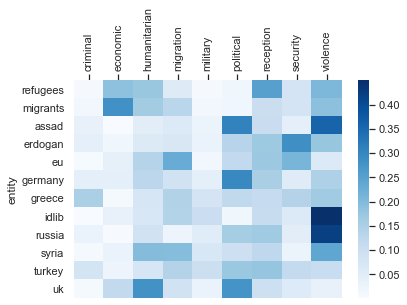

In [96]:
framed_entities = load_pickle('greece_framed_entities')
aggr_frames = aggregate_frames(framed_entities)

frame_heatmap(aggr_frames)

In [ ]:
framed_entities = load_pickle('channel_framed_entities')
aggr_frames = aggregate_frames(framed_entities)

frame_heatmap(aggr_frames,'channel')


In [ ]:
framed_entities = load_pickle('tigray_framed_entities')
aggr_frames = aggregate_frames(framed_entities)

frame_heatmap(aggr_frames,'tigray')

In [ ]:
framed_entities = load_pickle('rohingya_framed_entities')
aggr_frames = aggregate_frames(framed_entities)

frame_heatmap(aggr_frames,'rohingya')

## Find frames timeline

In [ ]:
the_word = 'germany'

def weekly_frames(entity,framed_words,event_name):
    merged_frames = framed_words.copy()
    merged_frames = merged_frames[merged_frames['entity'] == entity]
    #print(merged_frames)
    merged_frames['week'] = pd.to_datetime(merged_frames['date'], format='%Y-%m-%d').dt.strftime('%W')

    aggr_frames = merged_frames.groupby(['entity','week'],as_index=False).count()
    
    #aggr_frames = merged_frames.groupby(['entity'],as_index=True).count()
    #frame_size = merged_frames.groupby(['entity','week'],as_index=False).size()
    aggr_frames.drop(['entity','framing_word','date','tweet_id'],axis=1,inplace=True)
    
    aggr_frames = aggr_frames.set_index('week').T
    #aggr_frames =  aggr_frames.groupby(aggr_frames.index)[aggr_frames.columns].first()

    aggr_frames = aggr_frames / aggr_frames.sum()
    
    tps = aggr_frames.T.div(aggr_frames.T.sum(1), axis=0)
    ax = tps.plot(kind='bar', stacked=True,title=f'{entity} frame development for {event_name}')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    figure = ax.get_figure()    
    figure.savefig(f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_{entity}_frames.png', dpi=400)

    return aggr_frames#,frame_size

aggr_frames = aggregate_frames(the_word,framed_entities)

aggr_frames

In [ ]:
event_name = 'greece'
framed_entities = load_pickle(f'{event_name}_framed_entities')
for entity in list(load_pickle(f'{event_name}_final_ents')['entity_x'][:10]):
    weekly_frames(entity,framed_words,event_name)

In [ ]:
event_name = 'channel'
framed_entities = load_pickle(f'{event_name}_framed_entities')
for entity in list(load_pickle(f'{event_name}_final_ents')['entity_x'][:10]):
    weekly_frames(entity,framed_words,event_name)

In [ ]:
event_name = 'tigray'
framed_entities = load_pickle(f'{event_name}_framed_entities')
for entity in list(load_pickle(f'{event_name}_final_ents')['entity_x'][:10]):
    weekly_frames(entity,framed_words,event_name)

In [ ]:
event_name = 'rohingya'
framed_entities = load_pickle(f'{event_name}_framed_entities')
for entity in list(load_pickle(f'{event_name}_final_ents')['entity_x'][:10]):
    weekly_frames(entity,framed_words,event_name)

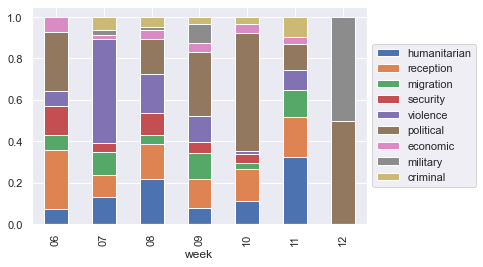

In [67]:
def plot_stacked_bar(aggr_frames):
    tps = aggr_frames.T.div(aggr_frames.T.sum(1), axis=0)
    ax = tps.plot(kind='bar', stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #here is the magic
    figure = ax.get_figure()    
    figure.savefig(f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_frames.png', dpi=400)
    

In [ ]:
fig = plt.figure()

for c,num in zip(countries, xrange(1,26)):
    df0=df[df['Country']==c]
    ax = fig.add_subplot(5,5,num)
    ax.plot(df0['Date'], df0[['y1','y2']])
    ax.set_title(c)

plt.tight_layout()
plt.show()

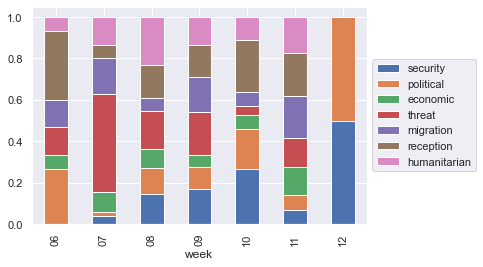

In [409]:
tps = aggr_frames.T.div(aggr_frames.T.sum(1), axis=0)
ax = tps.plot(kind='bar', stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #here is the magic

In [307]:
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

frame = 'easiness'

ax1 = px.line(aggr_frames0, x="week", y=[frame],render_mode='webgl')
ax2 = px.line(aggr_frames1,x="week", y=[frame],render_mode='webgl')
ax3 = px.line(aggr_frames2,x="week", y=[frame],render_mode='webgl')
ax4 = px.line(aggr_frames3,x="week", y=[frame],render_mode='webgl')
ax5 = px.line(aggr_frames4,x="week", y=[frame],render_mode='webgl')
ax6 = px.line(aggr_frames5,x="week", y=[frame],render_mode='webgl')

#ax2 = px.line(frame_size, x="date", y=['size'],render_mode='webgl')

#ax2.update_traces(yaxis='y2')
fig.add_traces(ax1.data + ax2.data + ax3.data + ax3.data + ax5.data + ax6.data)

fig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))

fig.show()

KeyError: 'variable'

In [ ]:
import plotly.express as px
for frame in aggr_frames.columns[2:]:
    print(frame)
    try:
        fig = px.line(aggr_frames, x="week", y=[frame], title=f'Frame bias towards {the_word}')
        fig.show()
    except ValueError:
        pass

## Get dependent words for entities

In [10]:
event_df = read_event_df('greece')
tagged_tweets = load_pickle('greece_tagged_tweets')
what_merged = load_pickle('greece_what_merged')


loaded 137462 tweets!


In [88]:
def find_biased_words(entity):
        rep_head = lemma.lemmatize(entity.lower())
        #add bias by word choice
        #print(entity,rep_head)
        frame_devices.append(rep_head) 
        if rep_head in tagged_tweets[tweet_id].text.lower() and len(rep_head)>1:
            #find all dependencies of the phrase head
            for related in range(len(ent_words)):
                ent_word_lemma = lemma.lemmatize(ent_words[related][1].lower())
                #print(f'Yes it is, related = {lemma.lentemmatize(cand_heads[related][1].lower(),pos=NOUN)}')
                if rep_head == ent_word_lemma:
                    related_word = lemma.lemmatize(ent_words[ent_words[related][2]-1][1].lower())
                    #add bias by labeling
                    frame_devices.append(related_word) 

#for entity in tqdm(what_merged.keys()):
entity = 'germany'
frame_devices=[]
ent_head = get_ent_head(entity)
for tweet_id in tqdm(event_df.index): 
    if entity in tagged_tweets[tweet_id].text.lower():
        ent_words = [[word.id, word.text,word.head] for sent in tagged_tweets[tweet_id].sentences for word in sent.words]
        find_biased_words(entity)
        #print(tagged_tweets[tweet_id].text.lower())
    #print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in tagged_tweets[tweet_id].sentences for word in sent.words], sep='\n')
    #print(len(cand_df['candidates']))
#print(ent_head)

  0%|          | 0/137462 [00:00<?, ?it/s]

In [92]:
import nltk
from nltk.corpus import stopwords
#print(stopwords.words('english'))

ne_list1 = str.split("refugee migrant eu uk immigrant seeker abiy addis aegean afewerki afeworki afghan afghanistan africa african america amnesty ahmed american amhara andrew ankara antony arab asean asia assad aung bachelet balukhali bangladesh bangladeshi biden blinken boris borisjohnson borrell brexit brit britain british brussels bulgaria burma burmese calais canada channel china commission commissioner corona coronavirus council covid cox dover dublin edirne england english erdoan erdogan eritrea eritrean ethiopia ethiopian euro europe european evros farage filippo fontelles france french freya_cole garneau geneva german germany grandi greece greek guterres haavisto hamdayet harris hindu hitsats houthi houthis idlib idp india indian iran iraq isaias isayas isi israel italy jammu jazeera jerry johnson josep junta justin kachin kadra karen kayin kamala kent kenya kurd labour linda lindat_g lebanon lesbos lesvos libya london maikadra manipur marc merkel michelle mizoram moria muslim mutraw myanmar nation nations nationshumanrights nato nazi nigel november oromia oromo pakistan patel president priti putin reuters rohingya rohingyas russia russian samri secretary shimelba shire somalia spain state sudan sudanese syria syrian tegaru tigrai tigrayan tigrayans thai thailand tory tplf trudeau trump turk turkey turkish unhcr unicef union united unsc us yemen youtube"," ")
ne_list2 = str.split("able absolutely access according account accountable across action actually affected agency agree agreement alive allegation allow allowed allowing almost alone along already also always ambassador amid among another answer anti anymore anyone anything area arent around arrived article asylum attempt attention away back based basic become believe best better black blame blocked born breaking bring brother build call called calling came cant case caught cause centre change claim claiming clear clearly close come coming comment commited commiting completely concern concerned condemn condition confirmed  continue continues could country course cover created credible crisis currently daily day deal dear decade decision demand department despite didnt difference different dire doesnt done dont east eastern easy either effort else endf enough especially ethnic even ever every everyone everything evidence evil exactly expect extremely face facility facing fact failed fake false federal feel find first found four forget free fuck fucking full genuine getting given giving great ground group happy imagine including issue instead isnt give going good half hand happen happened happening hard head heading held high horn hour however huge idea image immediate immediately independent information inside internal internally interview investigate investigation issue join journalist keep kind know known lack land landing largest last latest leader least left let letting level lie like likely little live living load local long longer look looking lost made mail major majority make making many massive matter maybe mean medium member middle might migration mind month morning mostly move much must name national near nearly need needed neighboring never news next nobody north northern nothing obviously office official one ongoing operation others paid part party pas past people perhaps person place plan please point post press prevails prime probably problem process programme provide public push putting question quite rather reach read real realise reality really reason received recent record remains remember report reported reporting resident response responsible rest result right said satellite say saying second seek seeker seeking seem seems seen send sending sent series service several shame share shit show side simple simply since single site situation small someone something soon sorry sort south source speak special spread stand star start started statement street still stop stopped stopping story stupid sure surely system take taken taking talk talking tell term testimony thank thanks thats there theyre thing think though thought three time today told took torn towards town tried true truth trying turn tweet understand unless urgent urgently used using video vice view virus visit voice wait waiting want wanted watch water week welcome well west western withdraw within without whats whilst white whole wing wish wonder wont word world worse wrong would year yesterday young youre"," ")
ne_list = ne_list1 + ne_list2 + stopwords.words('english')

In [93]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                stopwords = ne_list,
                min_font_size = 10).generate(" ".join(frame_devices))

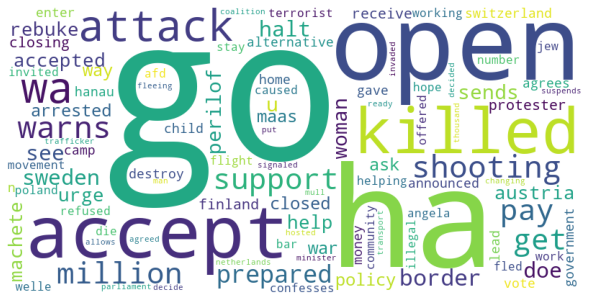

In [94]:
import matplotlib.pyplot as plt

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# TESTING:

In [ ]:


for tweet in tqdm(range(len(tweets_corpus))):
    print(tweets_corpus[tweet])
    np_heads = [[word.id, word.text,word.head,word.deprel] for sent in tagged_tweets[tweet].sentences for word in sent.words]
    print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in tagged_tweets[tweet].sentences for word in sent.words], sep='\n')
    #print(np_heads)
    ph_ids = set([np_heads[i][2] for i in range(len(np_heads))])
    ph_words = [np_heads[i-1][1] for i in ph_ids]

    word_pairs = [(np_heads[word][1], np_heads[np_heads[word][2]-1][1]) for word in range(len(np_heads)) if np_heads[word][2] != 0]
    #print(word_pairs)
    
    compounds = [[np_heads[i][1]+'_'+np_heads[np_heads[i][2]-1][1]] for i in range(len(np_heads)) if 'compound' in np_heads[i][3]]
    print(compounds)
    
    advmods = [[np_heads[i][1]+'_'+np_heads[np_heads[i][2]-1][1]] for i in range(len(np_heads)) if np_heads[i][3]=='advmod']
    print(advmods)
    
    amods = [[np_heads[i][1]+'_'+np_heads[np_heads[i][2]-1][1]] for i in range(len(np_heads)) if np_heads[i][3]=='amod']
    print(amods)
    for pair in word_pairs:
        phrase = pair[0]+'_'+pair[1]

    #print(model.most_similar('illegal_immigrant'))

    
    """#print(len(cand_df['candidates']))
    candidate_list = cand_df['candidates']
    for cand in cand_df['candidates']:
        #print(cand[2])
        #print(get_head(str(cand)))
        for phrase_head in cand[2]:
            #print(phrase_head)
            #if str(cand[1]) in str(tweet):
            if str(phrase_head) in str(tweet) and len(phrase_head)>2:
                #print(phrase_head)
                ph_words = [np_heads[i-1][1] for i in phrase_heads]
                #print(ph_words)
                for related in range(len(np_heads)):
                    if phrase_head == np_heads[related][1]:
                        pass
                        #print(f'checking {phrase_head}_{np_heads[np_heads[related][2]-1][1]}')
                  for frame_property in list(frame_properties.keys()):
                        for seed_word in frame_properties[frame_property]:
                        try:
                            for related in range(len(np_heads)):
                                #print(np_heads[related])
                                #if cand[1] == np_heads[related][1]:
                                if phrase_head == np_heads[related][1]:
                                    print(f'checking {seed_word} and {phrase_head}_{np_heads[np_heads[related][2]-1][1]}')
                                    #cand_frames[seed_word][phrase_head].append(model.similarity(seed_word,np_heads[np_heads[related][2]-1][1]))
                                #[cand_frames[seed_word][cand].append(model.similarity(seed_word,np_heads[np_heads[related][2]+1][1])) if cand == np_heads[related][1] else print('') for related in range(len(np_heads))]
                                except KeyError:
                                pass"""